# Classical ML Review

- Classification: Logistic Regression, KNN, Decision Trees, Random Forests, GBMs
- Clustering: k-Means
- Dimension Reduction: PCA
- Metrics: Precision, Recall, F1, ROC Curve, PR Curve

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.cluster import *
from sklearn.decomposition import *
from sklearn.neighbors import *
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)

In [2]:
def plot_data(X, y, model=None, h=0.01, figsize=(6, 6), s=20, alpha=0.7, edgecolor='black'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    fig, ax = plt.subplots(figsize=figsize)
    
    classes = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    if model is not None:
        yhat = model.predict(grid).reshape(xx.shape)
        ax.contourf(xx, yy, yhat, alpha=0.1, cmap=plt.cm.rainbow)
        plt.axis('tight')
    
    for i, color in zip(classes, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color, label=f'$y={i}$', edgecolor=edgecolor, s=s, alpha=alpha)
    
    plt.axis('tight')
    ax.set(aspect='equal', xlabel='$x_1$', ylabel='$x_2$')
    ax.legend(loc='best')
    plt.show()

In [3]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=3., random_state=seed, shuffle=True)
X.shape, y.shape

((1000, 2), (1000,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

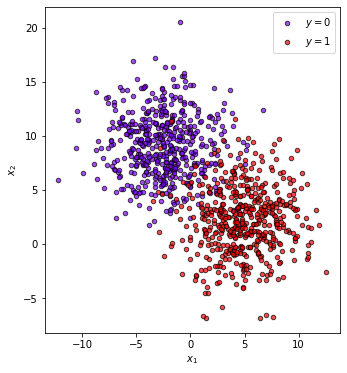

In [5]:
plot_data(X, y)

## Logistic Regression

In [6]:
class LogisticRegressionModel:
    def __init__(self, multiclass=True):
        self.multiclass = multiclass
        self._activation_fn = self._sigmoid if not multiclass else self._softmax
        self._loss_fn = self._binary_crossentropy if not multiclass else self._crossentropy
        
    def fit(self, X, y, num_iters=1000, lr=.1):
        num_features = X.shape[1]
        num_targets = len(np.unique(y)) if self.multiclass else 1
        Y = self._one_hot(y).T if self.multiclass else y[None, :]
        self._init_params(num_features, num_targets)
        for i in range(num_iters):
            yhat = self._activation_fn(self.weights @ X.T + self.bias)
            loss = self._loss_fn(y, yhat)
            dw, db = self._grads(X, Y, yhat)
            self.weights -= lr * dw
            self.bias -= lr * db
            lr *= (num_iters - 1) / num_iters

    def predict_proba(self, X):
        return self._activation_fn(self.weights @ X.T + self.bias)
            
    def predict(self, X):
        if not self.multiclass:
            y_pred = self.predict_proba(X).round()
        else:
            y_pred = self.predict_proba(X).T.argmax(axis=-1)
        return y_pred.T
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    @staticmethod
    def _sigmoid(z):
        return 1 / (1 + np.exp(-z))
        
    @staticmethod
    def _softmax(z):
        exps = np.exp(z - np.max(z))
        return exps / np.sum(exps)
    
    @staticmethod
    def _binary_crossentropy(y, yhat, eps=1e-9):
        yhat = np.clip(yhat, eps, 1-eps)
        loss = - np.sum(y * np.log(yhat + eps) + (1 - y) * np.log(1 - yhat + eps)) / len(y)
        return loss.item()

    @staticmethod
    def _crossentropy(y, yhat, eps=1e-9):
        yhat = np.clip(yhat, eps, 1-eps)
        loss = -np.sum(np.log(yhat[y, np.arange(len(y))])) / len(y)
        # print(loss)
        return loss.item()
    
    @staticmethod
    def _one_hot(y):
        y = y.flatten()
        Y = np.zeros((len(y), len(np.unique(y))))
        Y[np.arange(len(y)), y] = 1
        return Y
    
    @staticmethod
    def _grads(X, Y, yhat):
        dw = 1 / X.shape[1] * (yhat - Y) @ X
        dw = np.clip(dw, -1, 1)
        db = np.sum(yhat - Y, axis=-1)[:, None]
        db = np.clip(db, -1, 1)
        return dw, db
    
    def _init_params(self, num_features, num_targets):
        self.weights = np.random.randn(num_targets, num_features)
        self.bias = np.zeros((num_targets, 1))

In [7]:
model = LogisticRegressionModel(multiclass=False)
model.fit(X_train, y_train, lr=0.01, num_iters=1000)
model.score(X_test, y_test)

0.96

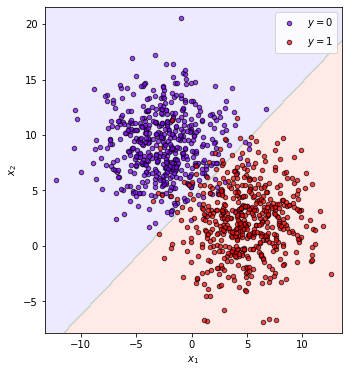

In [8]:
plot_data(X, y, model=model, h=0.1)

In [9]:
%%timeit

model = LogisticRegressionModel(multiclass=False)
model.fit(X_train, y_train, lr=0.01, num_iters=1000)
model.score(X_test, y_test)

52.4 ms ± 80.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%%timeit

model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

1.01 ms ± 3.22 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## KNN

In [11]:
def knn(X, y, k):
    def nearest_neighbors(X, k):
        norm = lambda x1, x2: np.sum((x1 - x2)**2)
        distances = np.array([[norm(x1, x2) for j, x2 in enumerate(X)] for i, x1 in enumerate(X)])
        # create (n,k) array neighbors where neighbors[i] = [nbr_idx_i1, ..., nbr_idx_ik]
        neighbors = np.argpartition(distances, k, axis=-1)[:, :k]
        return neighbors
    neighbors = nearest_neighbors(X, k)
    y_pred = np.array([np.median([y[idx] for idx in row]).round().astype(int) for row in neighbors])
    return y_pred

y_pred = knn(X_train, y_train, 2)
accuracy_score(y_train, y_pred)

0.9542857142857143

In [12]:
class KNNModel:
    def __init__(self, k=1, metric='euclidean', classification=True):
        self.k = k
        self.metric = metric
        self.classification = classification
        
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, x):
        x = np.array(x)
        x = x if len(x.shape) > 1 else x[None, :]
        distances = self._get_distances(self.X, x=x)
        neighbors = self._get_neighbors(distances.T)
        y_pred = np.array([self._majority_vote(example) for example in neighbors])
        return y_pred
    
    def score(self, x, y):
        y_pred = self.predict(x)
        if self.classification:
            score = accuracy_score(y, y_pred)
        else:
            score = mean_squared_error(y, y_pred)
        return score
    
    def _dist(self, x1, x2):
        if self.metric == 'euclidean':
            dist = np.sum((x1 - x2)**2)
        elif self.metric == 'cosine':
            dist = np.dot(x1 - x2, x1 - x2) / np.sqrt(np.dot(x1, x1) * np.dot(x2, x2))
        return dist
    
    def _get_distances(self, X, x=None):
        if x is not None:
            distances = np.array([[self._dist(x1, x2) for j, x2 in enumerate(x)] for i, x1 in enumerate(self.X)])
        else:
            distances = np.array([[self._dist(x1, x2) for j, x2 in enumerate(self.X)] for i, x1 in enumerate(self.X)])
        return distances
    
    def _get_neighbors(self, distances):
        return np.argpartition(distances, self.k, axis=-1)[:, :self.k]
    
    def _majority_vote(self, row):
        if self.classification:
            vote = np.median([self.y[idx] for idx in row]).round().astype(int)
        else:
            vote = np.mean([self.y[idx] for idx in row])
        return vote

In [13]:
model = KNNModel(k=5)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.95

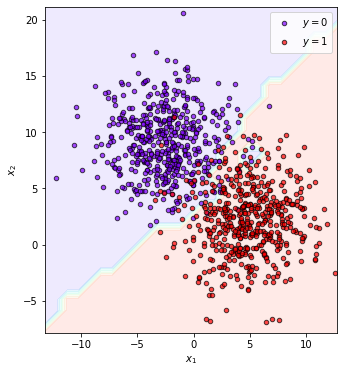

In [14]:
plot_data(X, y, model=model, h=1)

In [15]:
%%timeit

model = KNNModel(k=5)
model.fit(X_train, y_train)
model.score(X_test, y_test)

439 ms ± 4.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
model.score(X_test, y_test)

2.43 ms ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Decision Trees